# Explore historical volatility and subsequent returns

While [volatility-returns](volatility-returns.ipynb) used standard-deviation of daily returns as a measure of volatility, this notebook uses the [Yang Zhang Volatility](https://stockviz.biz/yang-zhang-volatility/) on weekly returns instead.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(schoRsch)
library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()

## list all TR indices

In [2]:
indices$NseTimeSeries() %>%
    filter(NAME %like% "%TR") %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    arrange(ST) %>%
    collect() %>%
    print(n=Inf)

# A tibble: 69 x 3
   NAME                                           ST         ET        
 * <chr>                                          <chr>      <chr>     
 1 NIFTY50 EQUAL WEIGHT TR                        1995-11-03 2019-11-22
 2 NIFTY MNC TR                                   1998-11-26 2019-11-22
 3 NIFTY 500 TR                                   1998-11-26 2019-11-22
 4 NIFTY FMCG TR                                  1998-11-26 2019-11-22
 5 NIFTY SERVICES SECTOR TR                       1999-06-01 2019-11-22
 6 NIFTY IT TR                                    1999-06-30 2019-11-22
 7 NIFTY 50 TR                                    1999-06-30 2019-11-22
 8 NIFTY BANK TR                                  2000-01-01 2019-11-22
 9 NIFTY PSE TR                                   2000-01-03 2019-11-22
10 NIFTY PHARMA TR                                2001-01-01 2019-11-22
11 NIFTY ENERGY TR                                2001-01-01 2019-11-22
12 NIFTY NEXT 50 TR                          

In [68]:
splitMarkYear1 <- "/2010"
splitMarkYear2 <- "2011/"

lookback <- 200/5 #weeks: to calculate volatility
lookforward <- 200/5 #weeks: to calculate cumulative returns
numBins <- 10 #number of bins: to bucket standard deviations
binLookback <- 100/5 #weeks: rolling window for bucketing standard deviations

In [55]:
indexName <- "NIFTY100 ALPHA 30 TR"
startDt <- as.Date("2003-01-01")

In [56]:
indexTs <- indices$NseTimeSeries() %>%
    filter (NAME == indexName & TIME_STAMP >= startDt) %>%
    select (TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

dailyXts <- xts(indexTs$CLOSE, indexTs$TIME_STAMP)
pXts <- to.period(dailyXts, "weeks")
names(pXts) <- c("Open","High","Low","Close")
dXts <- weeklyReturn(dailyXts)
dXts <- dXts[-1,]

In [69]:
sdTs <- volatility(pXts, n=lookback, N=50, calc="yang.zhang")
cumEqRets <- 100*rollapply(dXts, lookforward, Return.cumulative)
allXts <- na.omit(merge(sdTs, stats::lag(cumEqRets, -lookforward)))

sdBins <- rollapply(allXts[,1], binLookback, function(X) {
    last(ntiles(data = data.frame(SD = coredata(X)), dv=1, bins=numBins))
})

allXts <- na.omit(merge(allXts, sdBins, stats::lag(dXts, -1)))

names(allXts) <- c('SD', 'RETURNS_FWD', 'BIN_SD', 'INDEX')

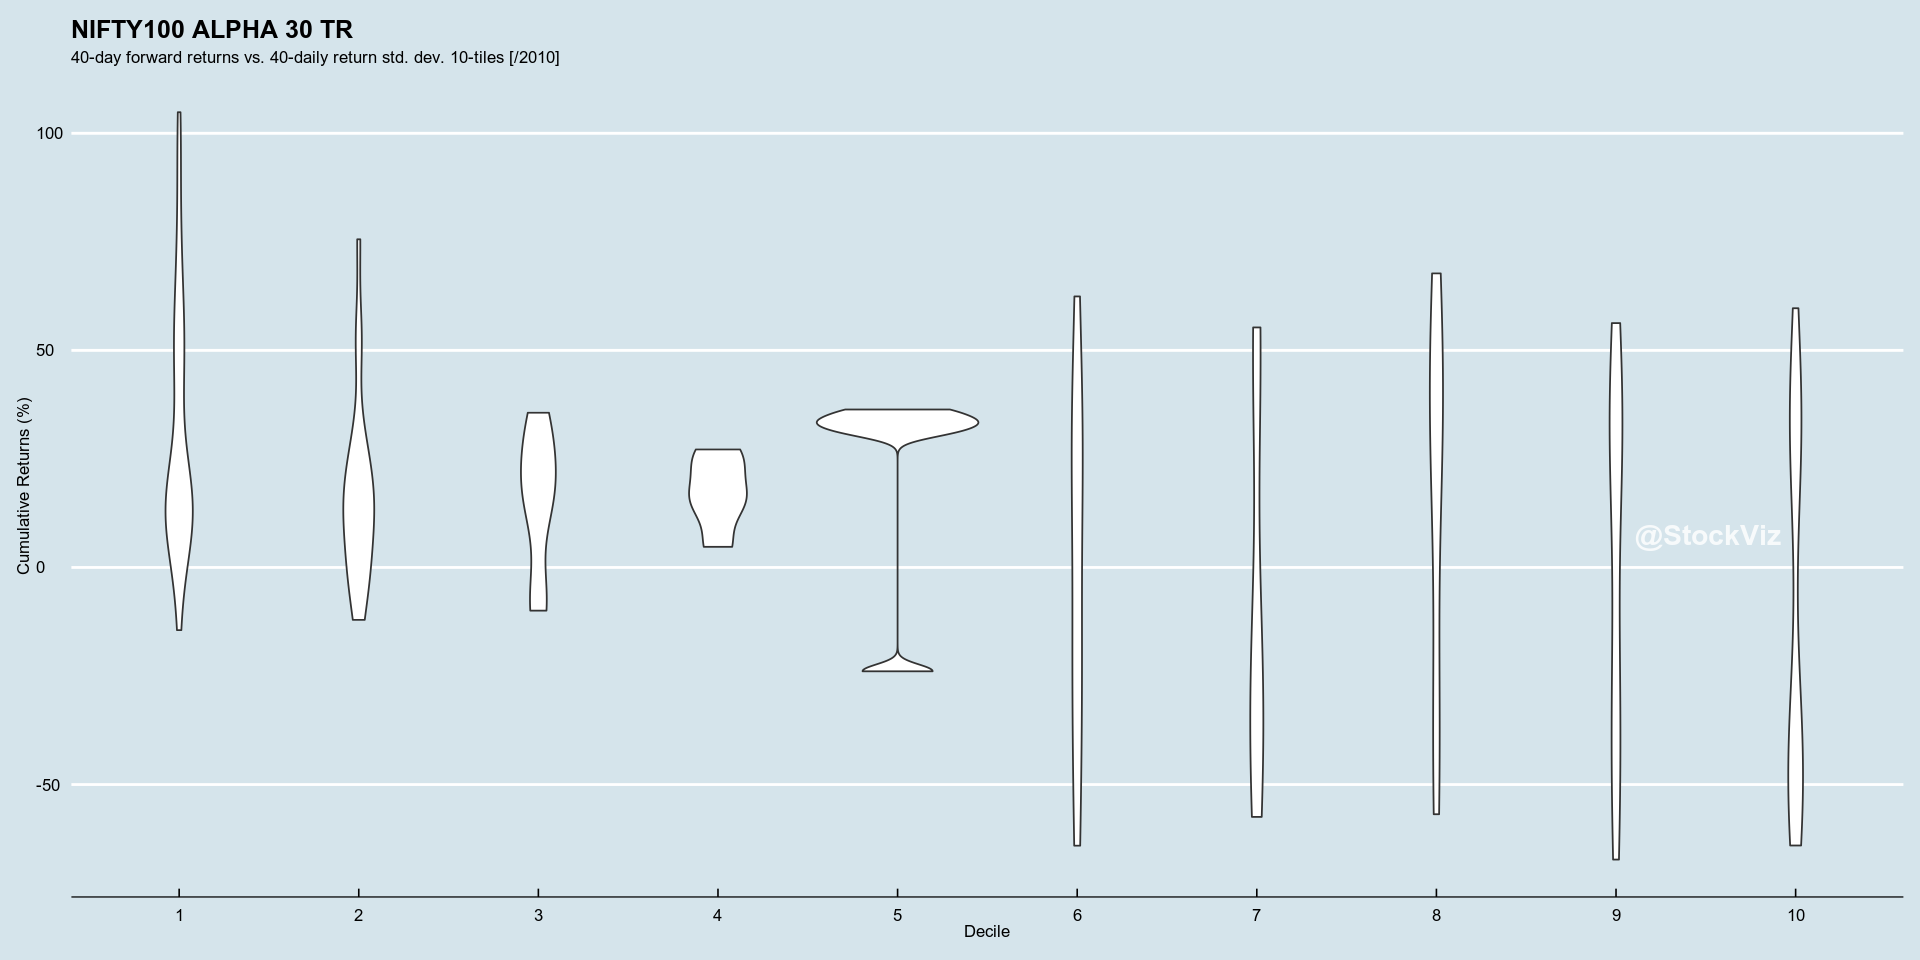

In [70]:
toPlot <- data.frame(allXts[splitMarkYear1,c(2, 3)])
toPlot$BIN_SD <- as.factor(toPlot$BIN_SD)

ggplot(toPlot, aes(x=BIN_SD, y=RETURNS_FWD)) + 
    theme_economist() +
    geom_violin() +
    labs(x='Decile', y='Cumulative Returns (%)', fill='', 
         title=indexName, 
         subtitle=sprintf("%d-day forward returns vs. %d-daily return std. dev. %d-tiles [%s]", lookforward, lookback, numBins, splitMarkYear1)) +
    annotate("text", x=numBins, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

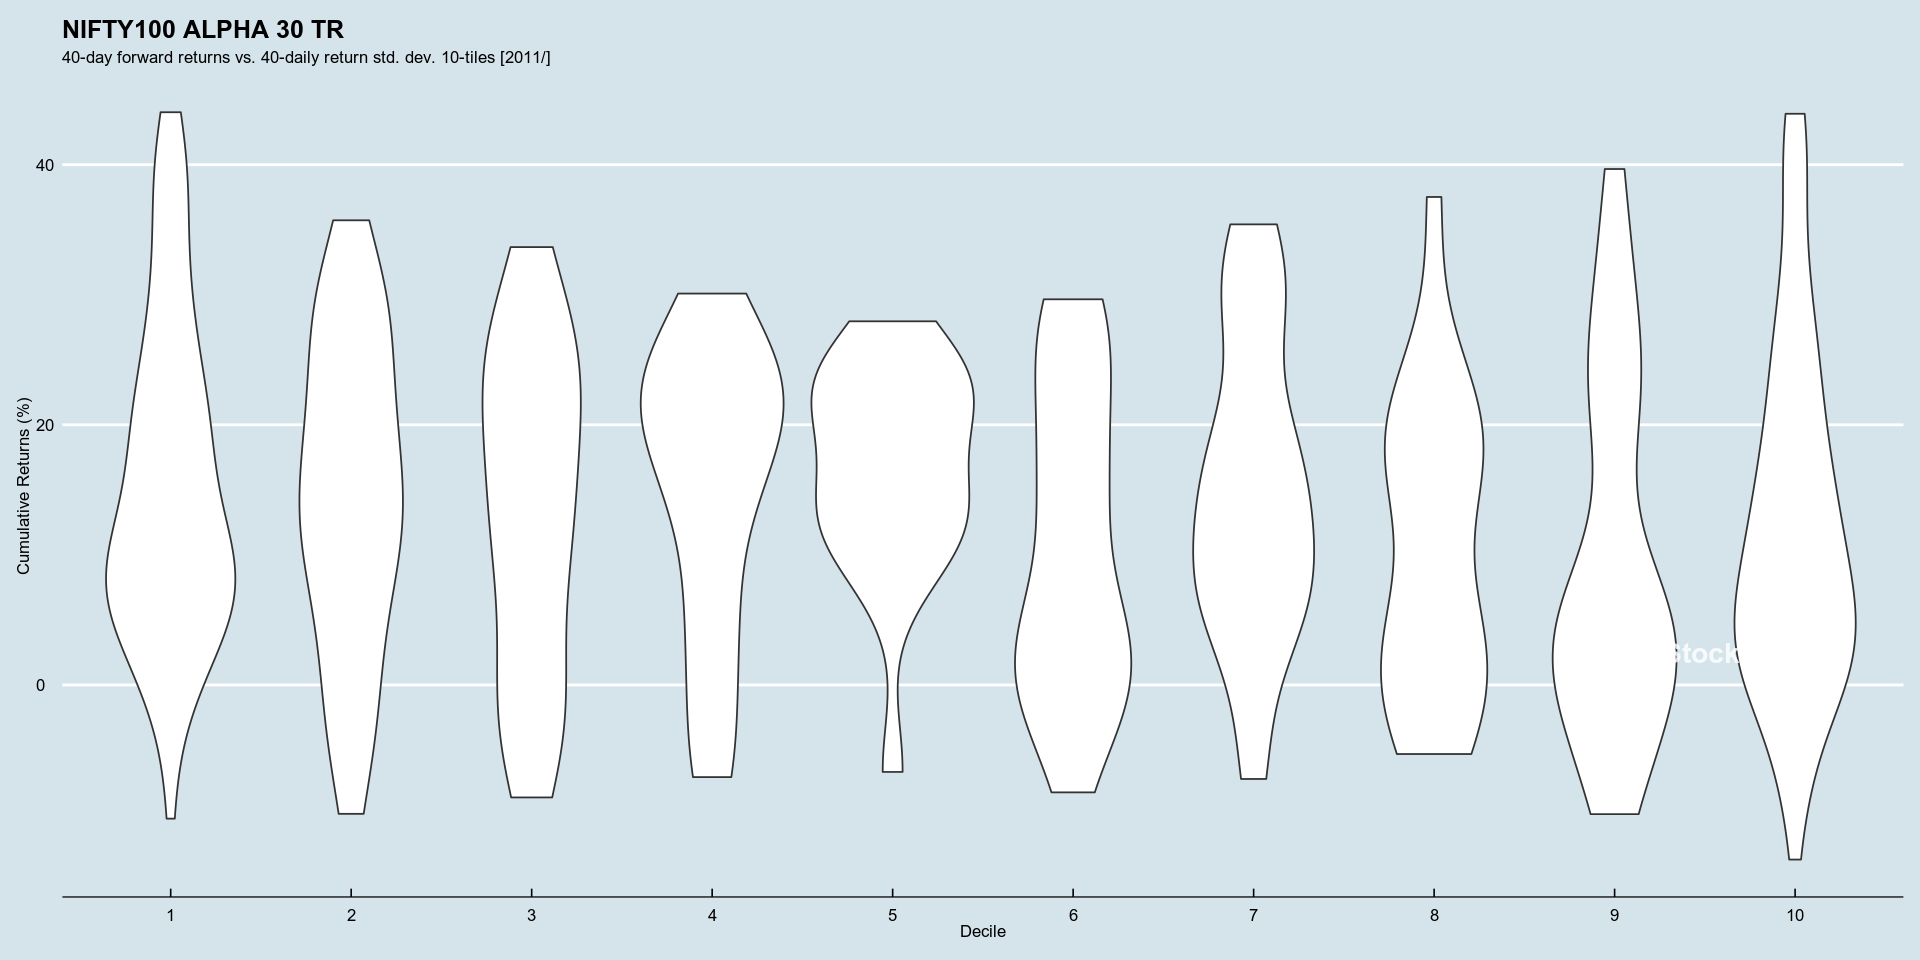

In [71]:
toPlot <- data.frame(allXts[splitMarkYear2,c(2, 3)])
toPlot$BIN_SD <- as.factor(toPlot$BIN_SD)

ggplot(toPlot, aes(x=BIN_SD, y=RETURNS_FWD)) + 
    theme_economist() +
    geom_violin() +
    labs(x='Decile', y='Cumulative Returns (%)', fill='', 
         title=indexName, 
         subtitle=sprintf("%d-day forward returns vs. %d-daily return std. dev. %d-tiles [%s]", lookforward, lookback, numBins, splitMarkYear2)) +
    annotate("text", x=numBins, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

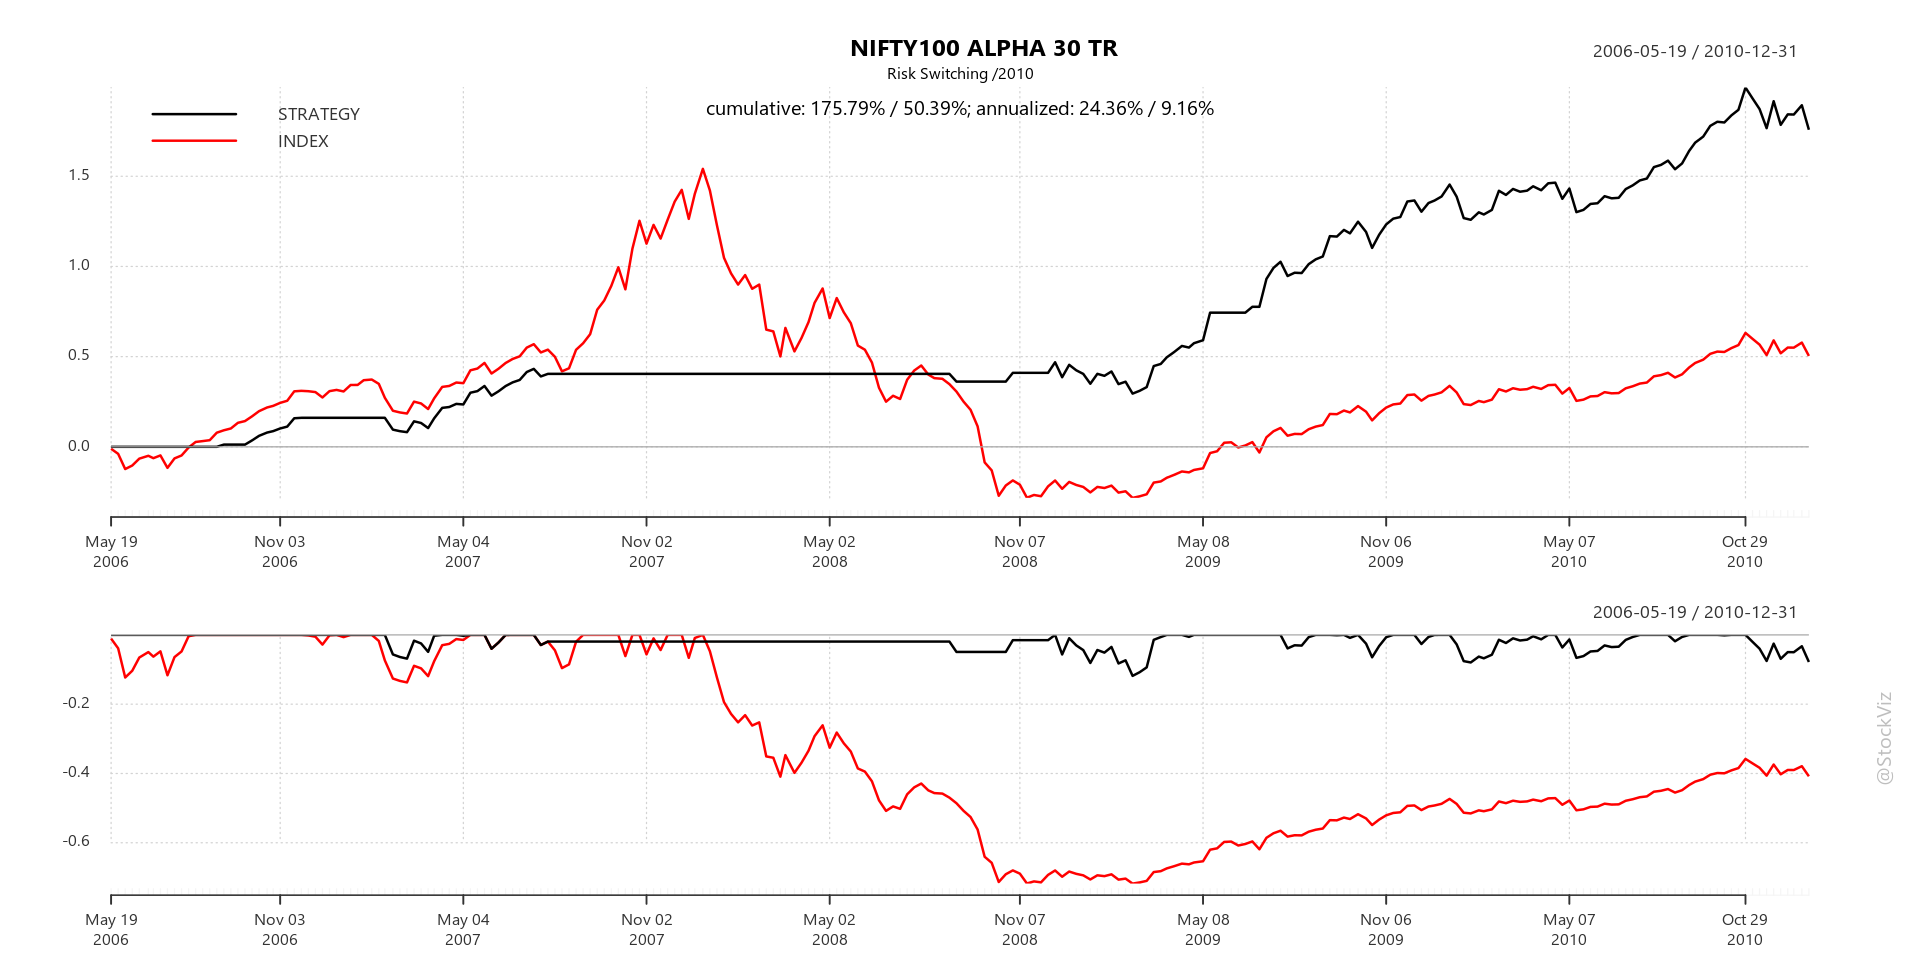

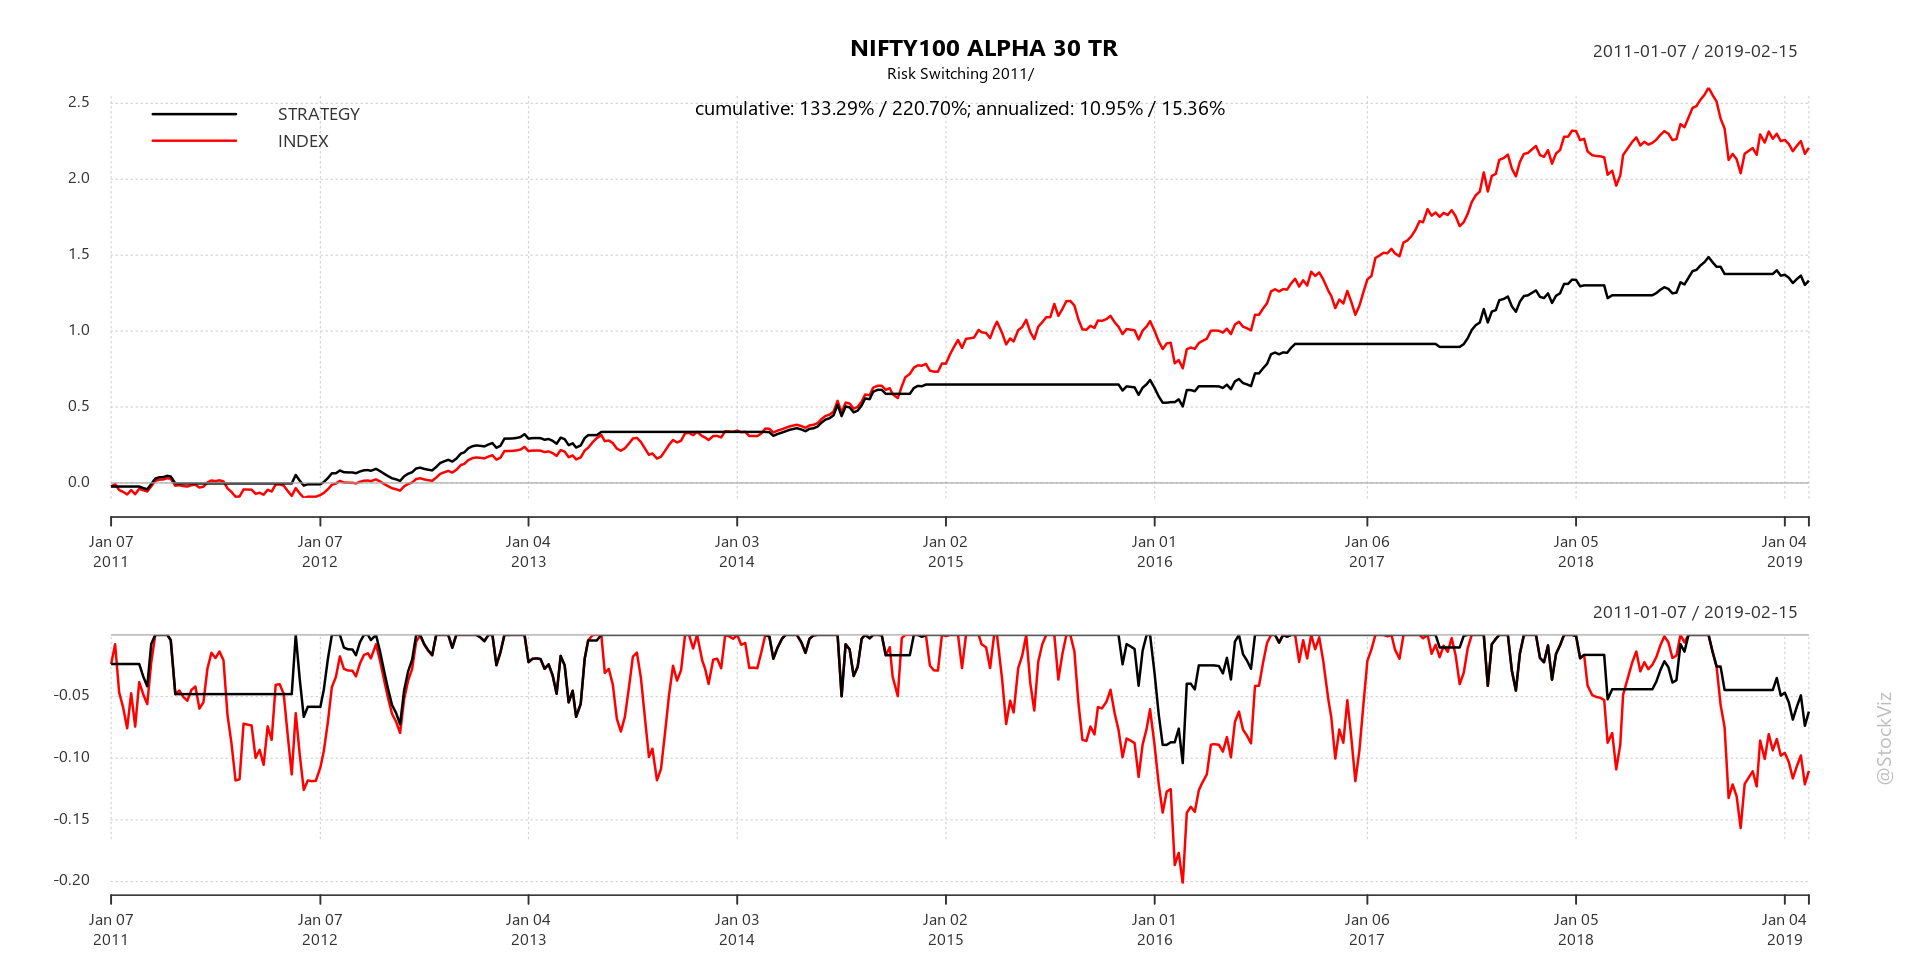

In [72]:
allXts$STRATEGY <- ifelse(allXts$BIN_SD %in% c(1, 2, 3, 4, 5), allXts$INDEX, 0)
Common.PlotCumReturns(allXts[splitMarkYear1, c('STRATEGY', 'INDEX')], sprintf("%s", indexName), sprintf("Risk Switching %s", splitMarkYear1))
Common.PlotCumReturns(allXts[splitMarkYear2, c('STRATEGY', 'INDEX')], sprintf("%s", indexName), sprintf("Risk Switching %s", splitMarkYear2))

In [73]:
annualRets <- 100*merge(yearlyReturn(cumprod(1+allXts$STRATEGY)), yearlyReturn(cumprod(1+allXts$INDEX)))
names(annualRets) <- c('STRATEGY', 'INDEX')
print(annualRets)

             STRATEGY      INDEX
2006-12-29 16.0918479  32.991800
2007-12-28 20.9816091  93.149070
2008-12-26  3.5745895 -68.300237
2009-12-31 64.1461790  61.652552
2010-12-31 15.4962081  15.496208
2011-12-30 -0.8784435  -9.071206
2012-12-28 33.2638788  36.066685
2013-12-27  1.1458562   8.017530
2014-12-26 23.3613938  33.711428
2015-12-24  1.8248356  15.601830
2016-12-30 14.1415087   9.178876
2017-12-29 22.1134984  47.224157
2018-12-28  1.1062899  -2.085391
2019-02-15 -1.3592394  -1.359239


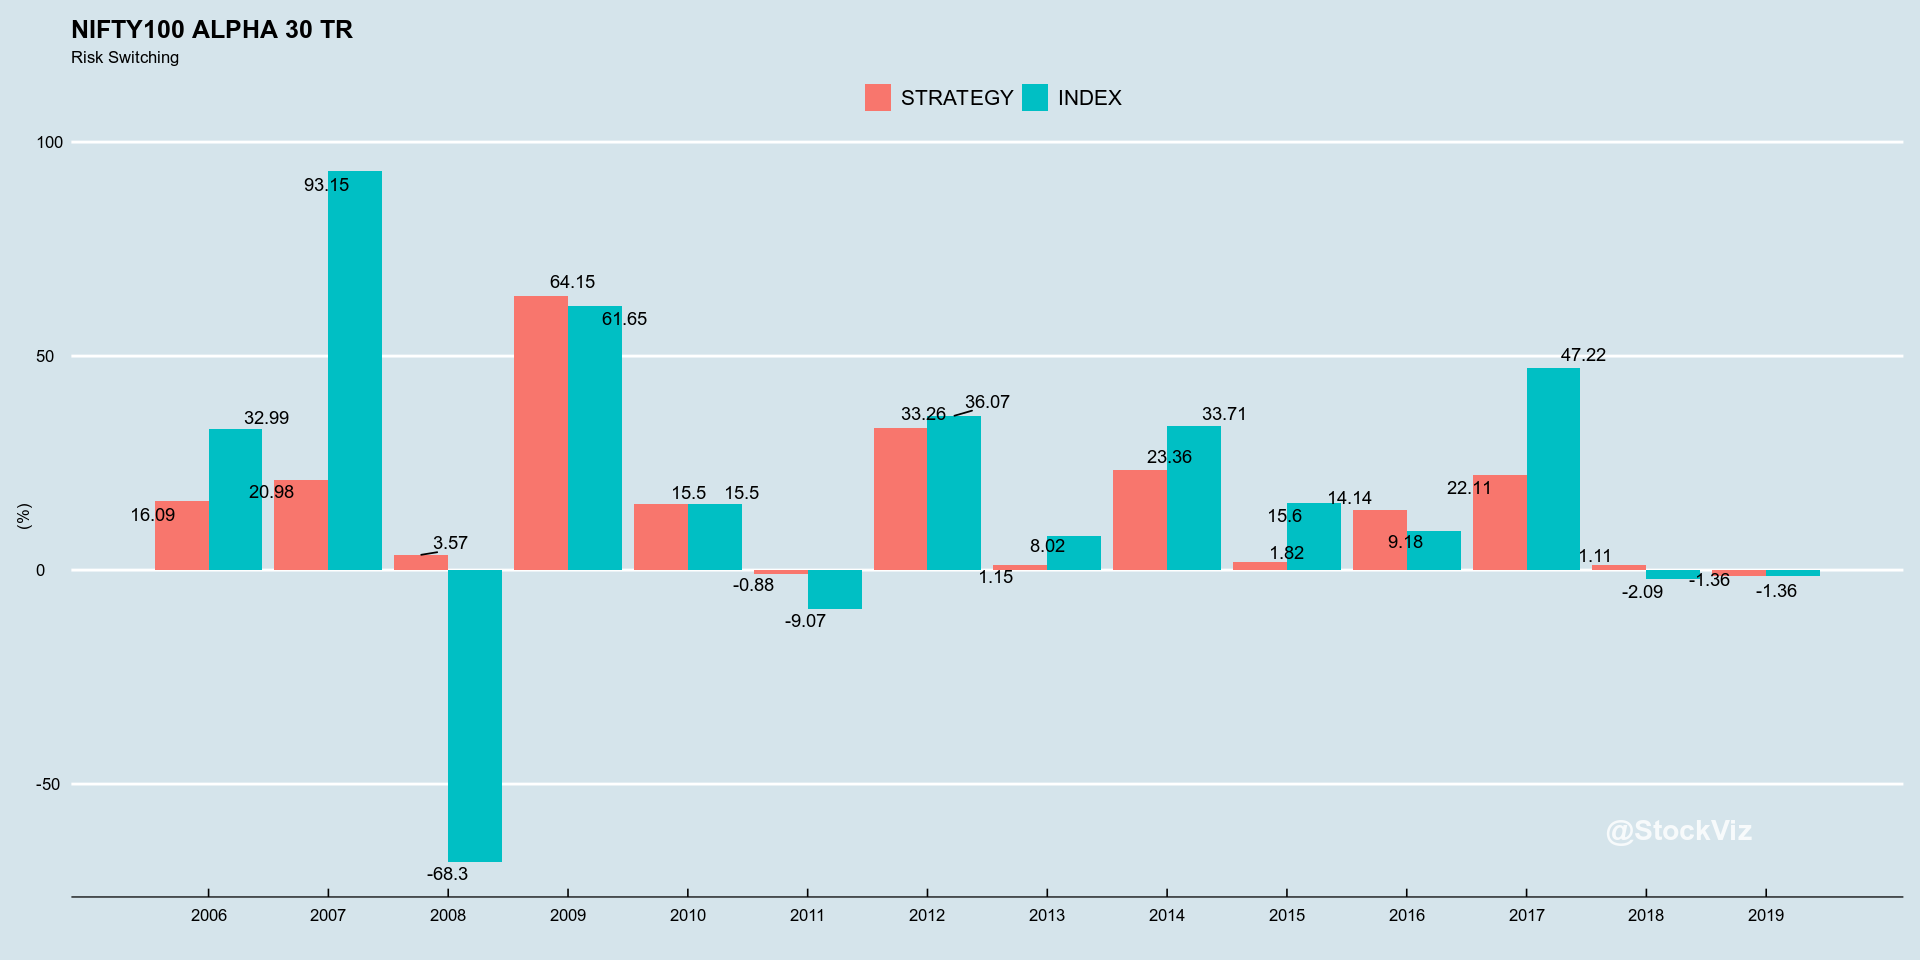

In [74]:
mDf <- data.frame(annualRets)
mDf$YEAR <- year(index(annualRets))
toPlot <- melt(mDf, id='YEAR')

ggplot(toPlot, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=mDf$YEAR, breaks=mDf$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=indexName, subtitle="Risk Switching") +
    annotate("text", x=max(mDf$YEAR), y=min(toPlot$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!